# Isomap Embedding: MNIST Handwritten Digits

(1797, 64)


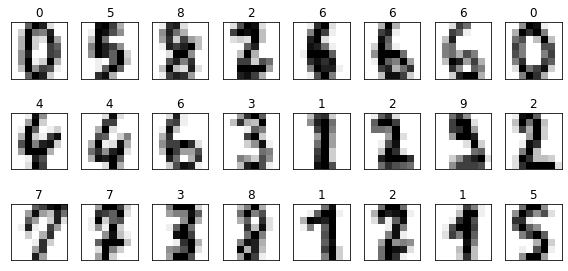

In [1]:
from sklearn.datasets import load_digits
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from matplotlib import offsetbox
import matplotlib.pyplot as plt
import numpy as np
import random
import math

X, y = load_digits(return_X_y=True)
print(X.shape)
random.seed(0)

rows, cols = 3, 8
fig, ax = plt.subplots(rows, cols, sharex='col', sharey='row',
                       subplot_kw=dict(xticks=[], yticks=[]),
                       figsize=(8,4))

for row in range(rows):
    for col in range(cols):
        n = np.random.randint(1796)+1    # show random samples
        im = ax[row, col].imshow(X[n].reshape((8,8)), cmap=plt.cm.gray_r)
        ax[row, col].set_title(y[n])

plt.tight_layout()
plt.show()

We'll use only 40% of the data to illustrate isomap embedding.

In [2]:
X2, _, y2,_ = train_test_split(X, y, test_size=0.6, stratify=y, random_state=42)
X2 = MinMaxScaler().fit_transform(X2)

print(X2.shape)
print(y2.shape)

(718, 64)
(718,)


## Define kNN graph and myIsomap classes

In [3]:
class knnGraph:
    def __init__(self, X, metric='euclidean', k=5):
        self.X = X
        self.k = k
        self.metric = metric
        
        # Get the pairwise distances
        D = pairwise_distances(self.X, self.X, 
                               metric=metric)
        
        # Set the distance of non-adjacent pts to Inf
        for i in range(len(X)):
            D[i, D[i,:] > D[i,np.argsort(D[i,:])[k]]] = np.Inf
        
        # Ensure that D is symmetric (knn graph is undirected)
        D = np.minimum(D, D.T)
        
        self.D = D

class myIsomap:
    def __init__(self, metric='euclidean', k=5):
        self.metric = metric
        self.k = k
        
    def fit_transform(self, X):
        
        # Create an instance of kNN graph
        kNNG = knnGraph(X, metric=self.metric, k=self.k)
        
        self.kNNG = kNNG
        self.X = X
        
        # Initialize D with the contents of kNNG.D
        D = np.zeros(kNNG.D.shape)
        for i in range(len(X)):
            for j in range(len(X)):
                D[i,j] = kNNG.D[i,j]
        
        # Use Floyd-Warshall algorithm to find the
        # all-pairs shortest path distance
        for k in range(len(X)):
            for i in range(len(X)):
                for j in range(i+1, len(X)):
                    D[i,j] = min(D[i,j], D[i,k] + D[k,j])
                    D[j,i] = D[i,j]
        
        self.D = D
        
        # Visualize the distance matrix
        #plt.figure(figsize=(8,8))
        #plt.imshow(self.D)
        #plt.title('Shortest Path Distance Matrix (from scratch)')
        #plt.colorbar(shrink=0.8)
        #plt.show()
        
        # Following Tenenbaum et al. (2000), we solve an eig problem
        self.D[self.D == np.inf] = 0
        n = len(self.X)
        H = np.eye(n) - np.ones((n, n))/n
        tau = -0.5 * H @ (self.D ** 2) @ H
        
        # Ensure symmetry by averaging out small errors
        tau = (tau + tau.T)/2
        
        # Eigenvalue decomposition
        eigvals, eigvecs = np.linalg.eig(tau)
        
        # Sort the eigenvalues in descending order
        idx = np.argsort(-eigvals)
        eigvals = eigvals[idx]
        eigvecs = eigvecs[:, idx]
                
        # Compute the embeddings and scores
        self.embedding = eigvecs[:,:2] @ np.diag(1/np.sqrt(eigvals[:2]))
        scores = tau.dot(self.embedding)
        return scores

## Perform Isomap Embedding from 64D to 2D

In [4]:
iso = myIsomap(metric='euclidean', k=30)
scores = iso.fit_transform(X2)

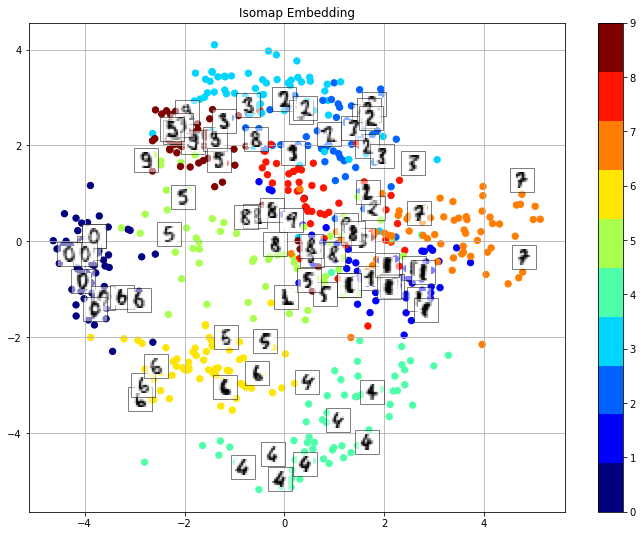

In [6]:
# Visualize the 2D embedding
fig, ax = plt.subplots(figsize=(12, 9))

for i in np.random.randint(len(y2),size=80):
    imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(X2[i].reshape((8,8)), 
                                                              cmap=plt.cm.gray_r, zoom=2), 
                                        xy=scores[i,:], xybox=scores[i,:], bboxprops=dict(alpha=0.5))
    ax.add_artist(imagebox)

plt.scatter(scores[:,0], scores[:,1], c=y2, s=40,
            cmap=plt.cm.get_cmap("jet", 10))
plt.title('Isomap Embedding')
plt.colorbar()
plt.grid()
plt.show()